## Transformation and Rotation of OSI SAF Sea Ice Drift vectors

This notebook demonstrates common transformations of sea-ice drift vector components. It was originally prepared as a companion to the manuscript documenting the first version of the OSI SAF sea-ice drift Climate Data Record (OSI-455):

_Lavergne, T. and Down, E.: A Climate Data Record of Year-Round Global Sea Ice Drift from the EUMETSAT OSI SAF, Earth Syst. Sci. Data Discuss. [preprint], https://doi.org/10.5194/essd-2023-40, in review, 2023._

The notebook contains python software to:
1. express displacement vectors (unit km over a time period, e.g. 24 hours) as mean velocity vectors (unit km/d, m/s, etc...);
2. rotate vector components from the original grid (EASE2 of PolStere) to any other grid (including the lat/lon projection to yield eastward/northward components);
3. average vector fields from daily to weekly and monthly periods.

We strongly encourage to read the discussion about the choice of vectorial representation for satellite-based sea-ice drift vectors in Lavergne and Down, 2023 (Sect. 4.2) before using the software. While it is technically possible to express the OSI SAF sea-ice drift vectors as velocities or onto other grids, the results must be interpreted with caution.

Although the software was developed for the OSI-455 CDR, we made it compatible with the OSI SAF near-real-time (NRT) sea-ice drift product as well (OSI-405). The two products and their documentation can be accessed from:
* OSI-455 (Climate Data Record) : https://osi-saf.eumetsat.int/products/osi-455
* OSI-405 (Near Real Time product) : https://osi-saf.eumetsat.int/products/osi-405-c

The software is provided AS-IS in hope that it is useful to the user of the OSI SAF sea-ice drift products. You are free to copy and modify the software for your needs. Please cite the notebook on Zenodo if you use it, and the data if you use it in your research.

We welcome feedback and bug reports either through the github page, or by email to Thomas Lavergne.


#### Imports of modules

In [1]:
import sys
import os
import xarray as xr
import numpy as np
from datetime import date, datetime, timedelta, time
from dateutil import rrule, relativedelta
import uuid
from copy import copy

import json

import pyproj
import pyresample as pr

from matplotlib import pylab as plt
import cmocean

import warnings
warnings.simplefilter("ignore")

## Software

### Software to find the OSI SAF sea-ice drift files on THREDDS.

All the OSI SAF sea-ice drift products are available on THREDDS using the OpenDAP protocol. It allows to run processing software directly towards the online files, without needing to download the files first (e.g. via FTP). Repeated access through THREDDS can be slower than downloading the files once and working on your local copies, but this is fine for demonstration purposes.

In [2]:
# input daily SID files
fn_patt = { 'cdr' : 'ice_drift_{a:}_ease2-750_cdr-v1p0_24h-{d:%Y%m%d}1200.nc',
            'cdr-ss' : 'ice_drift_{a:}_ease2-750_cdr-v1p0-{i:}_24h-{d:%Y%m%d}1200.nc',
            'nrt' : 'ice_drift_{a:}_polstere-625_multi-oi_{d:%Y%m%d}1200-{d2:%Y%m%d}1200.nc',
            'nrt-ss' : 'ice_drift_{a:}_polstere-625_{i:}_{d:%Y%m%d}1200-{d2:%Y%m%d}1200.nc'}

indirs = None
if indirs is None:
    # access through THREDDS/OpenDAP
    paths = {'cdr':'https://thredds.met.no/thredds/dodsC/osisaf/met.no/reprocessed/ice/drift_455m_files/merged/',
             'cdr-ss':'https://thredds.met.no/thredds/dodsC/osisaf/met.no/reprocessed/ice/drift_455m_files/single_sensor/',
             'nrt':'https://thredds.met.no/thredds/dodsC/osisaf/met.no/ice/drift_lr/merged/',
             'nrt-ss':'https://thredds.met.no/thredds/dodsC/osisaf/met.no/ice/drift_lr/single_sensor/'}
    jsond = json.dumps(paths, sort_keys=True, indent=4)
else:
    # load json file with path to input directories (if the daily SID files are downloaded to a local disk)
    # an example json file (prepare_monthly_osisaf_sic_opendap.json) is provided to demonstrate the format
    #   expected for the json file (but the effect will be the same as setting indirs to None: read from
    #   THREDDS/opendap)
    with open(indirs, 'r') as f:
        paths = json.load(f)
        
def find_sid_file(dt, area, source='cdr', return_filename=False):
    """Locate a sea-ice drift file and return it as an xarray Dataset (or just the filename)."""
    ss = None
    if source.startswith('cdr-'):
        ss = '-'.join(source.split('-')[1:])
        source = 'cdr-ss'
    elif source.startswith('nrt-'):
        ss = '-'.join(source.split('-')[1:])
        source = 'nrt-ss'

    ssdir = ''
    if ss is not None:
        ssdir = ss

    fn = fn_patt[source].format(a=area, d=dt, i=ss, d2=dt+timedelta(days=2))
    fn = os.path.join(paths[source],ssdir,'{:%Y/%m/}'.format(dt),fn)
    try:
        # this url exists, return it
        ds = xr.open_dataset(fn)
        # print("Open {}".format(fn))
        if return_filename:
            return fn
        else:
            return ds
    except OSError:
        # no valid file at this url, check the next rule
        print("WARNING: could not find OSI SAF SID v1 file for {} {} with pattern\n-> {}".format(area, dt, fn))
        return None
 
def get_month_first_last_date(dt):
    """Return the first and last day of a month corresponding to a date."""
    first_day = date(dt.year,dt.month,1)
    last_day = first_day + relativedelta.relativedelta(months=1)-timedelta(days=1)
    return first_day, last_day

def get_week_first_last_date(dt):
    """Return the first and last day of a (ISO) week corresponding to a date."""
    isoy, isow, wday = dt.isocalendar()
    first_day = date.fromisocalendar(isoy,isow,1)
    last_day = date.fromisocalendar(isoy,isow,7)
    return first_day, last_day

# DEMONSTRATION
area = 'nh'
dt = date(2020,3,10)

print(find_sid_file(dt, area, source='cdr', return_filename=True))
print(get_month_first_last_date(date(2020,2,20)))

# prepare a dict of several OSI SAF sea-ice drift files for later demonstration
ds = dict()
ds['cdr'] = find_sid_file(dt, area, source='cdr')
ds['cdrss'] = find_sid_file(dt, area, source='cdr-ssmis-f18')
ds['nrt'] = find_sid_file(dt, area, source='nrt')
ds['nrtss'] = find_sid_file(dt, area, source='nrt-amsr2-gw1')

https://thredds.met.no/thredds/dodsC/osisaf/met.no/reprocessed/ice/drift_455m_files/merged/2020/03/ice_drift_nh_ease2-750_cdr-v1p0_24h-202003101200.nc
(datetime.date(2020, 2, 1), datetime.date(2020, 2, 29))


## Transformation routines

In [3]:
# we want to systematically warn the user what fields were post-processed from the original components
comment = 'This variable is not part of the product, it was computed from dX and dY'

### Express Displacement as Velocity

The OSI SAF sea ice drift product holds (net Lagrangian) displacements over a 24 or 48 hours period (units km). To express these displacement as (mean daily) velocities, we divide the components by the time duration of the
displacement. There are two flavours of time duration:
1. the _nominal_ duration (24h for the CDR, 48h for the NRT product);
2. the _actual_ duration of each vector (maps of start and end time, see Fig. 4 in the ESSD paper).

These routines also support unit transformations (e.g. from km/day to m/s or cm/s).

In [4]:
def get_drift_duration(ds, method='nominal-duration', units='D'):
    """Return the duration of the drift vectors, either nominal or actual."""
    valid_methods = ('nominal-duration', 'actual-duration')
    if method not in valid_methods:
        raise ValueError('Wrong method for the time duration: should be one of {}'.format(valid_methods))
    if method == 'nominal-duration':
        t0 = ds['time_bnds'].to_numpy()[0,0]
        t1 = ds['time_bnds'].to_numpy()[0,1]
    elif method == 'actual-duration':
        try:
            # the CDR files have t0 and t1
            t0 = ds['t0'].to_masked_array()[0]
            t1 = ds['t1'].to_masked_array()[0]
        except:
            # the NRT files have dt0 and dt1 (seconds) that must be combined with
            #    the file-level t0 and t1
            t0 = ds['time_bnds'].to_numpy()[0,0].astype('datetime64[s]')
            t1 = ds['time_bnds'].to_numpy()[0,1].astype('datetime64[s]')
            dt0 = ds['dt0'].to_masked_array()[0]
            dt1 = ds['dt1'].to_masked_array()[0]
            t0 += dt0
            t1 += dt1
    
    duration = t1 - t0
    duration = duration / np.timedelta64(1,units)
    return duration

def express_displacement_as_velocity(ds, method='nominal-duration', units='km/d'):
    """Divide the components of the displacement vector by its duration to yield a (mean) velocity vector."""
    # decode requested units:
    try:
        ul,ut = units.split('/')
    except:
        raise ValueError("Broken unit for velocity, must be '<length>/<time>'")
    
    if ul == 'km':
        fac = 1
    elif ul == 'm':
        fac = 1000
    elif ul == 'cm':
        fac = 100000
    else:
        raise ValueError("Unsupported unit, the unit for length must be km, m, or cm")
        
    if ut == 'd':
        unitD = 'D'
    elif ut == 'h':
        unitH = 'h'
    elif ut == 's':
        unitD = 's'
    else:
        raise ValueError("Unsupported unit, the unit for time must be d, h, or s")
    
    # get duration
    duration = get_drift_duration(ds, method, units=unitD)
    
    # normalize the components by the drift duration
    vX = fac * ds['dX'] / duration
    vY = fac * ds['dY'] / duration
    
    # store in the dataset object
    ds['vX'] = ds['dX'].copy()
    ds['vY'] = ds['dY'].copy()
    ds['vX'][:] = vX
    ds['vY'][:] = vY
    
    # edit attributes to make good CF variables (including units)
    for a in ('X', 'Y'):
        vname = 'v'+a
        ds[vname].attrs['units'] = units
        ds[vname].attrs['long_name'] = ds['d'+a].long_name.replace('displacement','velocity')
        ds[vname].attrs['standard_name'] = ds['d'+a].standard_name.replace('displacement','velocity')
        ds[vname].attrs['ancillary_variables'] = 'status_flag'
        ds[vname].attrs['comment'] = comment
        
    return ds

# DEMONSTRATION

# Compute durations for the various sources, expressed in different units
units = ('D', 'h', 'h', 's')
for isrc, src in enumerate(('cdr', 'cdrss', 'nrt', 'nrtss')):
    u = units[isrc]
    durN = get_drift_duration(ds[src], units=u)
    durA = get_drift_duration(ds[src], method='actual-duration', units=u)
    print(src.upper(), 'Nominal duration', durN, 'Actual duration (min/mean/max) {:.2f} {:.2f} {:.2f} {}'.format(durA.min(), durA.mean(), durA.max(), u))
    
# Transform displacements to velocities, using different units
units = ('km/d', 'm/s', 'cm/s', 'km/d')
for isrc, src in enumerate(('cdr', 'cdrss', 'nrt', 'nrtss')):
    u = units[isrc]
    ds[src] = express_displacement_as_velocity(ds[src], method='nominal-duration', units=u)
    print(src.upper(),'in',u)
    print('Velocity vX (min/mean/max) {:.2f} {:.2f} {:.2f} {}'.format(
        ds[src]['vX'].min(), ds[src]['vX'].mean(), ds[src]['vX'].max(), ds[src]['vX'].units))
    print('Velocity vY (min/mean/max) {:.2f} {:.2f} {:.2f} {}'.format(
        ds[src]['vY'].min(), ds[src]['vY'].mean(), ds[src]['vY'].max(), ds[src]['vY'].units))

CDR Nominal duration 1.0 Actual duration (min/mean/max) 1.00 1.00 1.00 D
CDRSS Nominal duration 24.0 Actual duration (min/mean/max) 18.89 23.99 27.96 h
NRT Nominal duration 48.0 Actual duration (min/mean/max) 48.00 48.00 48.00 h
NRTSS Nominal duration 172800.0 Actual duration (min/mean/max) 146387.00 173122.52 194377.00 s
CDR in km/d
Velocity vX (min/mean/max) -29.04 -2.21 15.57 km/d
Velocity vY (min/mean/max) -32.60 -2.32 24.80 km/d
CDRSS in m/s
Velocity vX (min/mean/max) -0.35 -0.02 0.20 m/s
Velocity vY (min/mean/max) -0.39 -0.03 0.26 m/s
NRT in cm/s
Velocity vX (min/mean/max) -25.14 2.16 34.01 cm/s
Velocity vY (min/mean/max) -35.03 -4.32 29.69 cm/s
NRTSS in km/d
Velocity vX (min/mean/max) -17.43 2.52 28.73 km/d
Velocity vY (min/mean/max) -22.53 -4.62 21.88 km/d


### Rotate components to other projections

The OSI SAF sea ice drift products are available on two set of projections:
* The CDR is on EASE2 (Lambert Azimumthal) polar grids with 75 km spacing;
* The NRT product is on Polar Stereographic grids with 625 km spacing.

In the product files, the dX and dY components of the drift vectors are along these projections, and we want to rotate/transform these to other projections. A special case is to rotate the components to a lat/lon projection, in which case the resulting components are the eastward/northward components.

The vector rotation involves two steps:
1. compute two unit vectors (ux and uy) defining the x and y axes of the rotation.
2. rotate the vector field by projecting its components onto the ux and uy vectors.

In the software below, we refer to two Coordinate Reference System (CRS): the 'from' CRS (EASE2 or PolarStereo) and the 'to' CRS (the target CRS for the rotation).

NB: We only rotate/transform the components, we do not regrid the location of the motion vectors to another grid. This can be done in a last step e.g. using pyresample or scipy.

TEST 1: Rotate all sources to the CDR projection (displacement)
cdr ref dX (min/mean/max) -29.04 -2.21 15.57 km
cdr ref dY (min/mean/max) -32.60 -2.32 24.80 km
cdr rotated to cdr dX (min/mean/max) -29.04 -2.21 15.57 km
cdr rotated to cdr dY (min/mean/max) -32.60 -2.32 24.80 km
cdrss rotated to cdr dX (min/mean/max) -29.91 -1.84 17.68 km
cdrss rotated to cdr dY (min/mean/max) -33.67 -2.72 22.34 km
nrt rotated to cdr dX (min/mean/max) -61.07 -2.59 44.16 km
nrt rotated to cdr dY (min/mean/max) -56.93 -7.93 48.89 km
nrtss rotated to cdr dX (min/mean/max) -54.07 -2.94 43.28 km
nrtss rotated to cdr dY (min/mean/max) -55.42 -10.08 41.37 km


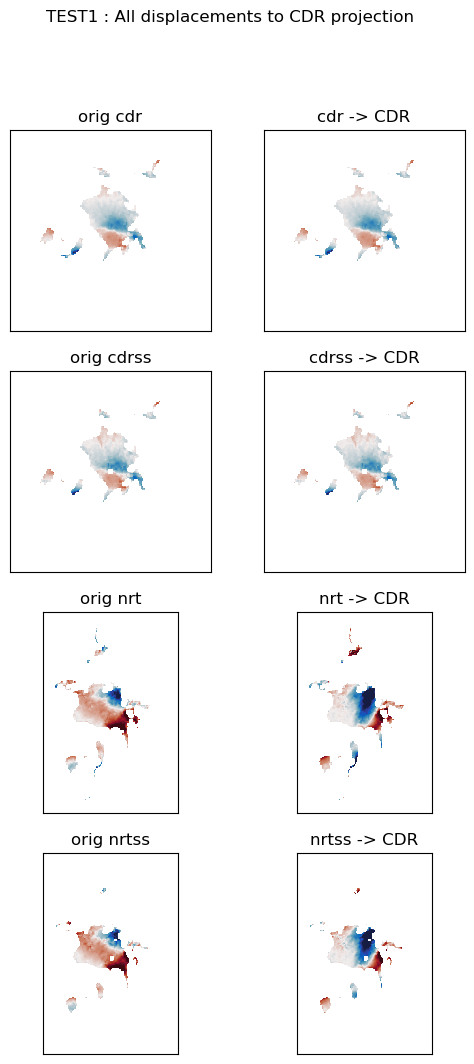

TEST 2: Rotate all sources to the CDR projection (velocity)
cdr ref vX (min/mean/max) -29.04 -2.21 15.57 km/d
cdr ref vY (min/mean/max) -32.60 -2.32 24.80 km/d
cdr rotated to cdr vX (min/mean/max) -29.04 -2.21 15.57 km/d
cdr rotated to cdr vY (min/mean/max) -32.60 -2.32 24.80 km/d
cdrss rotated to cdr vX (min/mean/max) -29.91 -1.84 17.68 km/d
cdrss rotated to cdr vY (min/mean/max) -33.67 -2.72 22.34 km/d
nrt rotated to cdr vX (min/mean/max) -30.54 -1.29 22.08 km/d
nrt rotated to cdr vY (min/mean/max) -28.47 -3.96 24.44 km/d
nrtss rotated to cdr vX (min/mean/max) -27.03 -1.47 21.64 km/d
nrtss rotated to cdr vY (min/mean/max) -27.71 -5.04 20.69 km/d


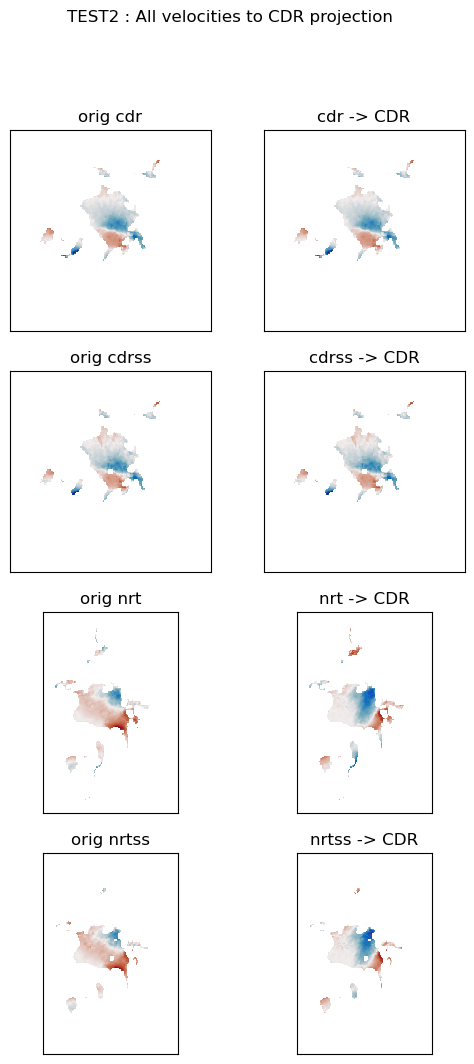

TEST 3: Rotate all sources to the lat/lon projection (velocity)
cdr rotated to latlon vX (min/mean/max) -25.86 2.66 25.76 cm/s
cdr rotated to latlon vY (min/mean/max) -42.94 -0.56 28.54 cm/s
cdrss rotated to latlon vX (min/mean/max) -27.10 2.15 25.76 cm/s
cdrss rotated to latlon vY (min/mean/max) -43.42 0.02 28.00 cm/s
nrt rotated to latlon vX (min/mean/max) -21.39 2.92 25.95 cm/s
nrt rotated to latlon vY (min/mean/max) -37.52 0.83 25.76 cm/s
nrtss rotated to latlon vX (min/mean/max) -18.21 3.27 26.56 cm/s
nrtss rotated to latlon vY (min/mean/max) -30.41 2.40 30.09 cm/s


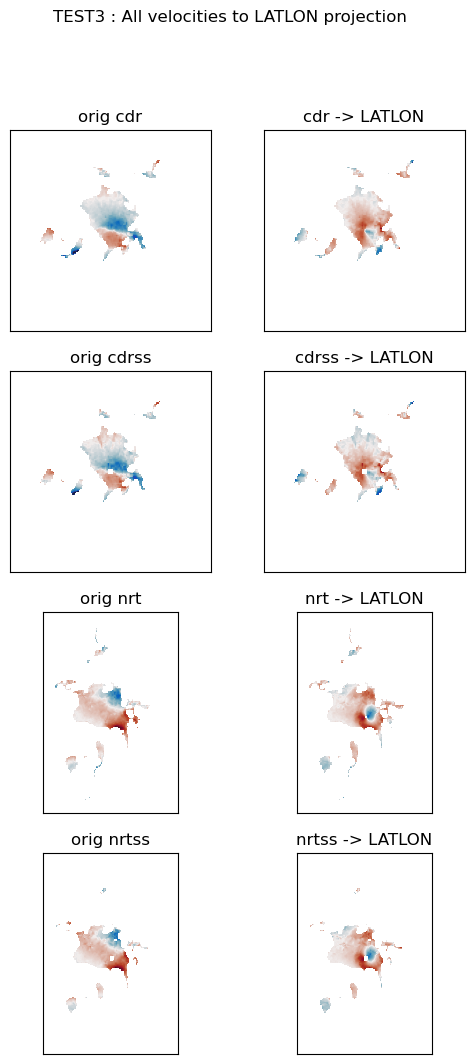

In [5]:
def get_rotation_unit_vectors(x_from, y_from, crs_from, crs_to):
    """Compute two sets of unit vectors (ux and uy) defining the x and y axes of the rotation.
    
    Args:
       x_from (2D array): x locations of the grid in the 'from' crs
       y_from (2D array): y locations of the grid in the 'from' crs
       crs_from (pyproj.CRS): pyproj object defining the 'from' crs
       crs_to (pyproj.CRS): pyproj object defining the 'to' crs
       
    Returns:
       ux (3D array): x and y components of the ux unit vector of the rotation in the 'from' crs.
       vx (3D array): x and y components of the uy unit vector of the rotation in the 'from' crs.
    
    Notes:
       -  this step is a pre-processing before the actual rotation of the vectors. The vectors to be
          rotated are not input parameters to the routine.
       -  x_from and y_from must be in units that can directly be entered the 'from' crs (e.g. meters
          or degrees) as no unit conversion is performed inside this routine.
    """
    # sanity check on the shape of the input parameters
    if x_from.shape != y_from.shape:
        raise ValueError("x_from and y_from must have the same shape.")
    if len(x_from.shape) != 2:
        raise ValueError("x_from and y_from must be 2D arrays.")
    
    # define the transform from one crs to the other
    transformer = pyproj.Transformer.from_crs(crs_from, crs_to)
    
    # transform x_from, y_from from the "from" crs to the "to" crs.
    x_to, y_to = transformer.transform(x_from, y_from)
    
    # in the "to" crs, compute a small increasing step in 'x' direction.
    #   its length does not matter, we will normalize to unit vectors later
    epsx_to = 0.1
    x2_to = x_to + epsx_to
    
    # if the "to" crs is geographic, then x is the longitude and we must wrap x2 to [-180;+180]
    if crs_to.is_geographic:
        x2_to = (x2_to + 180) % 360 - 180
        
    # transform the x_to + epsx_to (ux direction) back into the "from" crs
    x_ux_from, y_ux_from = transformer.transform(x2_to, y_to,
                    direction=pyproj.enums.TransformDirection.INVERSE)
    
    # define the ux vectors in the "from" crs
    ux = np.stack(((x_ux_from - x_from),(y_ux_from - y_from)), axis=2)
    
    # normalize each vector to be unit vectors
    ux_norm = (ux[:,:,0]**2 + ux[:,:,1]**2)**0.5
    ux /= np.repeat(ux_norm[:,:,None], 2, axis=2)
    
    # define uy which is perpendicular to ux
    uy = ux.copy()
    uy[:,:,0] = -ux[:,:,1]
    uy[:,:,1] = +ux[:,:,0]
    
    # done, return
    return ux, uy

def apply_vector_rotation(vec_x, vec_y, ux, uy):
    """Rotate 2D vector fields (vec_x, vec_y) onto axes defined by unit vectors ux and uy
    
    Args:
       vec_x (2D array): x components of the vectors to be rotated
       vec_y (2D array): y components of the vectors to be rotated
       ux (2D array) : unit vector defining the x-direction of the rotation
       uy (2D array) : unit vector defining the y-direction of the rotation
       
    Returns:
       rot_x (2D array): x components of the rotated vectors.
       rot_y (2D array): y components of the rotated vectors.
    
    """
    # sanity check on the shape of the input parameters
    if vec_x.shape != vec_y.shape:
        raise ValueError("vec_x and vec_y must have the same shape.")
    if len(vec_x.shape) != 2:
        raise ValueError("vec_x and vec_y must be 2D arrays.")
    
    # prepare an (nx,ny,2) array for the input (vec_x,vec_y) vector
    vec = np.stack((vec_x,vec_y), axis=2)
    
    # use the einsum notation to compute dot products at each (nx,ny) locations
    rot_x = np.einsum('ijk,ijk->ij',vec,ux)
    rot_y = np.einsum('ijk,ijk->ij',vec,uy)
    
    # done, return
    return rot_x, rot_y

def rotate_vectors(x_from, y_from, vec_x, vec_y, crs_from, crs_to):
    """Compute the rotation unit vectors then apply the rotation."""
    ux, uy = get_rotation_unit_vectors(x_from, y_from, crs_from, crs_to)
    rot_x, rot_y = apply_vector_rotation(vec_x, vec_y, ux, uy)
    return rot_x, rot_y

def rotate_icedrift_vectors(ds, crs_to, velocity=False, crs_tag=None):
    """Rotate the vectors in a Dataset to the crs_to projection."""
    # A user can specify a tag for the crs to be rotated to. Default is
    #   to call it 'crs2'
    if crs_tag is None:
        crs_tag = 'crs2'
    
    # A user can ask for the velocity vectors to be rotated. Default is
    #   to rotate the displacement vectors. 
    fromv = 'd'
    if velocity:
        fromv = 'v'
    
    # prepare input for rotate_vectors()
    adef, _ = pr.utils.load_cf_area(ds)
    crs_from = adef.crs
    x_from, y_from = np.meshgrid(adef.projection_x_coords, adef.projection_y_coords)
    vec_x = ds[fromv+'X'].to_masked_array()[0]
    vec_y = ds[fromv+'Y'].to_masked_array()[0]
    
    # call rotate_vectors()
    u_rot, v_rot = rotate_vectors(x_from, y_from, vec_x, vec_y, crs_from, crs_to)
    
    # store in ds
    ds[fromv+'X_'+crs_tag] = ds[fromv+'X'].copy()
    ds[fromv+'Y_'+crs_tag] = ds[fromv+'Y'].copy()
    ds[fromv+'X_'+crs_tag][:] = u_rot
    ds[fromv+'Y_'+crs_tag][:] = v_rot
    
    # Edit attributes to make good CF variables (including units)
    for a in ('X', 'Y'):
        vname = fromv+a+'_'+crs_tag
        ds[vname].attrs['long_name'] = ds[fromv+a].long_name.replace('axis of the grid','axis of crs: '+crs_tag)
        ds[vname].attrs[crs_tag + '_projstr'] = crs_to.to_proj4()
        ds[vname].attrs['ancillary_variables'] = 'status_flag'
        ds[vname].attrs['comment'] = comment
        # if the target crs is a lat/lon projection, then adapt the standard name to
        #    the eastward/northward version
        if crs_to.is_geographic:
            ds[vname].attrs['standard_name'] = \
               {'X':'eastward','Y':'northward'}[a] + '_' + \
               ds[vname].attrs['standard_name'].replace('_'+a.lower()+'_','_')
    
    return ds

# DEMONSTRATION

# First demo : rotate all sources to the CDR projection (displacement)
print("TEST 1: Rotate all sources to the CDR projection (displacement)")
fig, ax = plt.subplots(nrows=4, ncols=2, figsize=(6,12))
adef,_ = pr.utils.load_cf_area(ds['cdr'])
crs_to = adef.crs
print('{} ref dX (min/mean/max) {:.2f} {:.2f} {:.2f} {}'.format('cdr',
        ds['cdr']['dX'].min(), ds['cdr']['dX'].mean(), ds['cdr']['dX'].max(), ds['cdr']['dX'].units))
print('{} ref dY (min/mean/max) {:.2f} {:.2f} {:.2f} {}'.format('cdr',
        ds['cdr']['dY'].min(), ds['cdr']['dY'].mean(), ds['cdr']['dY'].max(), ds['cdr']['dY'].units))

for isrc, src in enumerate(('cdr', 'cdrss', 'nrt', 'nrtss')):
    ds[src] = rotate_icedrift_vectors(ds[src], crs_to, crs_tag='cdr')
    print('{} rotated to {} dX (min/mean/max) {:.2f} {:.2f} {:.2f} {}'.format(src, 'cdr',
        ds[src]['dX_cdr'].min(), ds[src]['dX_cdr'].mean(), ds[src]['dX_cdr'].max(), ds[src]['dX_cdr'].units))
    print('{} rotated to {} dY (min/mean/max) {:.2f} {:.2f} {:.2f} {}'.format(src, 'cdr',
        ds[src]['dY_cdr'].min(), ds[src]['dY_cdr'].mean(), ds[src]['dY_cdr'].max(), ds[src]['dY_cdr'].units))
    ax[isrc,0].imshow(ds[src]['dX'][0], vmin=-30, vmax=+30, cmap=cmocean.cm.balance)
    ax[isrc,0].set_title('orig {}'.format(src))
    ax[isrc,0].set_xticks([]); ax[isrc,0].set_yticks([]);
    ax[isrc,1].imshow(ds[src]['dX_cdr'][0], vmin=-30, vmax=+30, cmap=cmocean.cm.balance)
    ax[isrc,1].set_title('{} -> CDR'.format(src))
    ax[isrc,1].set_xticks([]); ax[isrc,1].set_yticks([]);

fig.suptitle("TEST1 : All displacements to CDR projection")
plt.show()

# Second demo : rotate all sources to the CDR projection (velocity).
print("TEST 2: Rotate all sources to the CDR projection (velocity)")
fig, ax = plt.subplots(nrows=4, ncols=2, figsize=(6,12))
adef,_ = pr.utils.load_cf_area(ds['cdr'])
crs_to = adef.crs
units = 'km/d'
ds['cdr'] = express_displacement_as_velocity(ds['cdr'], method='nominal-duration', units=units)
print('{} ref vX (min/mean/max) {:.2f} {:.2f} {:.2f} {}'.format('cdr',
        ds['cdr']['vX'].min(), ds['cdr']['vX'].mean(), ds['cdr']['vX'].max(), ds['cdr']['vX'].units))
print('{} ref vY (min/mean/max) {:.2f} {:.2f} {:.2f} {}'.format('cdr',
        ds['cdr']['vY'].min(), ds['cdr']['vY'].mean(), ds['cdr']['vY'].max(), ds['cdr']['vY'].units))

for isrc, src in enumerate(('cdr', 'cdrss', 'nrt', 'nrtss')):
    ds[src] = express_displacement_as_velocity(ds[src], method='nominal-duration', units=units)
    ds[src] = rotate_icedrift_vectors(ds[src], crs_to, crs_tag='cdr', velocity=True)
    print('{} rotated to {} vX (min/mean/max) {:.2f} {:.2f} {:.2f} {}'.format(src, 'cdr',
        ds[src]['vX_cdr'].min(), ds[src]['vX_cdr'].mean(), ds[src]['vX_cdr'].max(), ds[src]['vX_cdr'].units))
    print('{} rotated to {} vY (min/mean/max) {:.2f} {:.2f} {:.2f} {}'.format(src, 'cdr',
        ds[src]['vY_cdr'].min(), ds[src]['vY_cdr'].mean(), ds[src]['vY_cdr'].max(), ds[src]['vY_cdr'].units))
    ax[isrc,0].imshow(ds[src]['vX'][0], vmin=-30, vmax=+30, cmap=cmocean.cm.balance)
    ax[isrc,0].set_title('orig {}'.format(src))
    ax[isrc,0].set_xticks([]); ax[isrc,0].set_yticks([]);
    ax[isrc,1].imshow(ds[src]['vX_cdr'][0], vmin=-30, vmax=+30, cmap=cmocean.cm.balance)
    ax[isrc,1].set_title('{} -> CDR'.format(src))
    ax[isrc,1].set_xticks([]); ax[isrc,1].set_yticks([]);

fig.suptitle("TEST2 : All velocities to CDR projection")
plt.show()

# third demo : rotate all sources to the latlong projection (velocity).
print("TEST 3: Rotate all sources to the lat/lon projection (velocity)")
fig, ax = plt.subplots(nrows=4, ncols=2, figsize=(6,12))
crs_to = pyproj.CRS('+proj=latlong +ellps=WGS84')
units = 'cm/s'

for isrc, src in enumerate(('cdr', 'cdrss', 'nrt', 'nrtss')):
    ds[src] = express_displacement_as_velocity(ds[src], method='actual-duration', units=units)
    ds[src] = rotate_icedrift_vectors(ds[src], crs_to, crs_tag='latlon', velocity=True)
    print('{} rotated to {} vX (min/mean/max) {:.2f} {:.2f} {:.2f} {}'.format(src, 'latlon',
        ds[src]['vX_latlon'].min(), ds[src]['vX_latlon'].mean(), ds[src]['vX_latlon'].max(), ds[src]['vX_latlon'].units))
    print('{} rotated to {} vY (min/mean/max) {:.2f} {:.2f} {:.2f} {}'.format(src, 'latlon',
        ds[src]['vY_latlon'].min(), ds[src]['vY_latlon'].mean(), ds[src]['vY_latlon'].max(), ds[src]['vY_latlon'].units))
    ax[isrc,0].imshow(ds[src]['vX'][0], vmin=-30, vmax=+30, cmap=cmocean.cm.balance)
    ax[isrc,0].set_title('orig {}'.format(src))
    ax[isrc,0].set_xticks([]); ax[isrc,0].set_yticks([]);
    ax[isrc,1].imshow(ds[src]['vX_latlon'][0], vmin=-30, vmax=+30, cmap=cmocean.cm.balance)
    ax[isrc,1].set_title('{} -> LATLON'.format(src))
    ax[isrc,1].set_xticks([]); ax[isrc,1].set_yticks([]);
    
fig.suptitle("TEST3 : All velocities to LATLON projection")
plt.show()

## Applications

### Compute monthly mean velocity in the lat/lon convention and compare to NSIDC (at ICDC)

The Integrated Climate Data Center ([ICDC](https://www.cen.uni-hamburg.de/en/icdc.html)) is part of the German Center for Earth System Research and Sustainability (CEN). It allows easy access to climate relevant data from in-situ measurements and satellite remote sensing.

ICDC distributes an added-value product on top of the NSIDC Pathfinder sea-ice motion dataset v4. NSIDC only distributes daily and weekly mean sea-ice motion fields, and only in their EASE polar projections. The ICDC added-value product includes monthly mean velocities, expressed both in the original EASE projection and along the lat/lon projection (eastward/northward components).

In the application below, we compute monthly mean sea-ice velocity vectors in our EASE2 product grid (similar but not identical to NSIDC's EASE grid) and in the lat/lon projection. We visually compare our results to those from ICDC.

In [6]:
# A routine to plot fields of vector components before and after rotation.
def plot_vector_components(vec_x, vec_y, rot_x, rot_y, ccrs_from, fig_title=None):
    """Plot maps of the x and y components before and after rotation."""
    import cmocean
    cmap = cmocean.cm.balance
    vmin,vmax = np.percentile(np.ma.masked_invalid(vec_x).compressed(),(1,99))
    
    fig, ax = plt.subplots(nrows=2, ncols=2, figsize=(9,9), sharex=True, sharey=True,
                           subplot_kw=dict(projection=ccrs_from))
    ax[0,0].coastlines()
    ax[0,0].imshow(vec_x,transform=ccrs_from, extent=ccrs_from.bounds, origin='upper',
               cmap=cmap, vmin=vmin, vmax=vmax)
    ax[0,0].set_title('original X component')
    ax[0,1].coastlines()
    ax[0,1].imshow(vec_y,transform=ccrs_from, extent=ccrs_from.bounds, origin='upper',
               cmap=cmap, vmin=vmin, vmax=vmax)
    ax[0,1].set_title('original Y component')

    ax[1,0].coastlines()
    ax[1,0].imshow(rot_x,transform=ccrs_from, extent=ccrs_from.bounds, origin='upper',
               cmap=cmap, vmin=vmin, vmax=vmax)
    ax[1,0].set_title('rotated X component')
    ax[1,1].coastlines()
    ax[1,1].imshow(rot_y,transform=ccrs_from, extent=ccrs_from.bounds, origin='upper',
               cmap=cmap, vmin=vmin, vmax=vmax)
    ax[1,1].set_title('rotated Y component')
    
    if fig_title:
        fig.suptitle(fig_title)
    
    return

In [7]:
# get access to the ICDC public data on THREDDS
area = 'sh'
ds_icdc = xr.open_dataset('https://icdc.cen.uni-hamburg.de/thredds/dodsC/icedrift_'+area)

def to_datetime(date):
    """
    Converts a numpy datetime64 object to a python datetime object 
    Input:
      date - a np.datetime64 object
    Output:
      DATE - a python datetime object
      
    From: https://gist.github.com/blaylockbk/1677b446bc741ee2db3e943ab7e4cabd
    """
    timestamp = ((date - np.datetime64('1970-01-01T00:00:00'))
                 / np.timedelta64(1, 's'))
    return datetime.utcfromtimestamp(timestamp)


# select a time index (each index is one month)
tindex = 481
nsidc_date = to_datetime(ds_icdc['time'][tindex].data)
print("Selected Month: {d:%b %Y}".format(d=nsidc_date))

Selected Month: Dec 2018


In [8]:
# Reverse-engineer a pyresample AreaDefinition object for the NSIDC grid since it is not
#   properly encoded in the file

# define a pyproj CRS for the NSICD product
nsidc_epsg = '3408'
if area == 'sh':
    nsidc_epsg = '3409'
crs_nsidc = pyproj.CRS.from_epsg(int(nsidc_epsg))

# compute corner coordinates from the corners of the lat/lon array
crs_latlon = pyproj.CRS('+proj=latlong +ellps=WGS84')
t = pyproj.transformer.Transformer.from_crs(crs_latlon, crs_nsidc)
nsidc_lon = (ds_icdc['lon'].data + 180) % 360 - 180
nsidc_lon[nsidc_lon==-180] = +180
nsidc_lat = ds_icdc['lat'].data
x0,y0 = t.transform(nsidc_lon[0,0], nsidc_lat[0,0],)
x1,y1 = t.transform(nsidc_lon[1,1], nsidc_lat[1,1],)
xe,ye = t.transform(nsidc_lon[-1,-1], nsidc_lat[-1,-1],)
sx = x1-x0
sy = y1-y0

# prepare the pyresample AreaDefinition object
area_extent = [x0-0.5*sx, ye+0.5*sy, xe+0.5*sx, y0-0.5*sy]
shape = ds_icdc['lon'].shape
adef_nsidc = pr.geometry.AreaDefinition('ease25','ease25','ease25', 'EPSG:'+nsidc_epsg,
                          shape[1], shape[0], area_extent)
# check we have it correct:
lons, lats = adef_nsidc.get_lonlats()
print('max difference in lon:', abs(lons-nsidc_lon).max())
print('min difference in lat:', abs(lats-nsidc_lat).max())

print("pyresample AreaDefinition for the NSIDC product:")
print(adef_nsidc)

max difference in lon: 4.5490912400580896e-05
min difference in lat: 4.901750685348816e-06
pyresample AreaDefinition for the NSIDC product:
Area ID: ease25
Description: ease25
Projection ID: ease25
Projection: {'R': '6371228', 'lat_0': '-90', 'lon_0': '0', 'no_defs': 'None', 'proj': 'laea', 'type': 'crs', 'units': 'm', 'x_0': '0', 'y_0': '0'}
Number of columns: 321
Number of rows: 321
Area extent: (-4023337.5904, 4023337.5904, 4023337.5904, -4023337.5904)


In [9]:
# find all the daily files of the OSI SAF CDR OSI-455 for the selected month.
first_day, last_day = get_month_first_last_date(nsidc_date)
osi455_files = []
for d in rrule.rrule(rrule.DAILY, dtstart=first_day,
                                        until=last_day):
    osi455_files.append(find_sid_file(d, area=area, return_filename=True))

print("Found {} OSI-455 files:\n{}".format(len(osi455_files), osi455_files))

Found 31 OSI-455 files:
['https://thredds.met.no/thredds/dodsC/osisaf/met.no/reprocessed/ice/drift_455m_files/merged/2018/12/ice_drift_sh_ease2-750_cdr-v1p0_24h-201812011200.nc', 'https://thredds.met.no/thredds/dodsC/osisaf/met.no/reprocessed/ice/drift_455m_files/merged/2018/12/ice_drift_sh_ease2-750_cdr-v1p0_24h-201812021200.nc', 'https://thredds.met.no/thredds/dodsC/osisaf/met.no/reprocessed/ice/drift_455m_files/merged/2018/12/ice_drift_sh_ease2-750_cdr-v1p0_24h-201812031200.nc', 'https://thredds.met.no/thredds/dodsC/osisaf/met.no/reprocessed/ice/drift_455m_files/merged/2018/12/ice_drift_sh_ease2-750_cdr-v1p0_24h-201812041200.nc', 'https://thredds.met.no/thredds/dodsC/osisaf/met.no/reprocessed/ice/drift_455m_files/merged/2018/12/ice_drift_sh_ease2-750_cdr-v1p0_24h-201812051200.nc', 'https://thredds.met.no/thredds/dodsC/osisaf/met.no/reprocessed/ice/drift_455m_files/merged/2018/12/ice_drift_sh_ease2-750_cdr-v1p0_24h-201812061200.nc', 'https://thredds.met.no/thredds/dodsC/osisaf/met.no

In [10]:
# Open all OSI-455 daily files as a "multi-file" Dataset
ds_osi455 = xr.open_mfdataset(osi455_files)
# Explore the first file in the list.
print(ds_osi455.isel(time=[0,]))

<xarray.Dataset>
Dimensions:                       (time: 1, nv: 2, xc: 144, yc: 144)
Coordinates:
  * time                          (time) datetime64[ns] 2018-12-01T12:00:00
  * xc                            (xc) float64 -5.362e+03 ... 5.362e+03
  * yc                            (yc) float64 5.362e+03 ... -5.362e+03
    lat                           (yc, xc) float32 dask.array<chunksize=(144, 144), meta=np.ndarray>
    lon                           (yc, xc) float32 dask.array<chunksize=(144, 144), meta=np.ndarray>
Dimensions without coordinates: nv
Data variables:
    Lambert_Azimuthal_Equal_Area  (time) int32 -2147483647
    time_bnds                     (time, nv) datetime64[ns] dask.array<chunksize=(1, 2), meta=np.ndarray>
    t0                            (time, yc, xc) datetime64[ns] dask.array<chunksize=(1, 144, 144), meta=np.ndarray>
    t1                            (time, yc, xc) datetime64[ns] dask.array<chunksize=(1, 144, 144), meta=np.ndarray>
    lat1                     

In [11]:
# Compute velocity vectors using the 'actual duration' method and express as m/s
#   This happens for each timestep of the multi-file dataset using groupy() and apply()
kwargs = {'method':'actual-duration', 'units':'m/s'}
ds_osi455 = ds_osi455.groupby('time', squeeze=False).apply(express_displacement_as_velocity,**kwargs)
# Explore the resulting velocity component 'vX'. 'vX' is along the original EASE2 projection (no rotation yet).
print(ds_osi455['vX'])

<xarray.DataArray 'vX' (time: 31, yc: 144, xc: 144)>
dask.array<concatenate, shape=(31, 144, 144), dtype=float32, chunksize=(1, 144, 144), chunktype=numpy.ndarray>
Coordinates:
  * time     (time) datetime64[ns] 2018-12-01T12:00:00 ... 2018-12-31T12:00:00
  * xc       (xc) float64 -5.362e+03 -5.288e+03 ... 5.288e+03 5.362e+03
  * yc       (yc) float64 5.362e+03 5.288e+03 ... -5.288e+03 -5.362e+03
    lat      (yc, xc) float32 dask.array<chunksize=(144, 144), meta=np.ndarray>
    lon      (yc, xc) float32 dask.array<chunksize=(144, 144), meta=np.ndarray>
Attributes:
    long_name:            component of the velocity along the x axis of the grid
    standard_name:        sea_ice_x_velocity
    units:                m/s
    grid_mapping:         Lambert_Azimuthal_Equal_Area
    ancillary_variables:  status_flag
    _ChunkSizes:          [  1 144 144]
    comment:              This variable is not part of the product, it was co...


In [12]:
# Transform the velocity vectors to the lat/lon projection.
#   This happens for each timestep of the multi-file dataset using groupy() and apply()
#   Note: this could be made more efficient by first defining the unit vectors of the rotation once,
#      then applying the rotation from the unit vectors to each timestep.
crs_to = pyproj.CRS('+proj=latlong +ellps=WGS84')
args = (crs_to,)
kwargs = {'crs_tag':'latlon', 'velocity':True}
ds_osi455 = ds_osi455.groupby('time', squeeze=False).apply(rotate_icedrift_vectors,args,**kwargs)
# Explore the resulting rotated velocity component 'vX_latlon'. Note the change of standard_name.
print(ds_osi455['vX_latlon'])

<xarray.DataArray 'vX_latlon' (time: 31, yc: 144, xc: 144)>
dask.array<concatenate, shape=(31, 144, 144), dtype=float32, chunksize=(1, 144, 144), chunktype=numpy.ndarray>
Coordinates:
  * time     (time) datetime64[ns] 2018-12-01T12:00:00 ... 2018-12-31T12:00:00
  * xc       (xc) float64 -5.362e+03 -5.288e+03 ... 5.288e+03 5.362e+03
  * yc       (yc) float64 5.362e+03 5.288e+03 ... -5.288e+03 -5.362e+03
    lat      (yc, xc) float32 dask.array<chunksize=(144, 144), meta=np.ndarray>
    lon      (yc, xc) float32 dask.array<chunksize=(144, 144), meta=np.ndarray>
Attributes:
    long_name:            component of the velocity along the x axis of crs: ...
    standard_name:        eastward_sea_ice_velocity
    units:                m/s
    grid_mapping:         Lambert_Azimuthal_Equal_Area
    ancillary_variables:  status_flag
    _ChunkSizes:          [  1 144 144]
    comment:              This variable is not part of the product, it was co...
    latlon_projstr:       +proj=longlat +ell

In [13]:
# Compute the monthly average of all components (the original displacements dX and dY,
#   the velocities in EASE2 projection vX and xY, and the rotated velocities vX_latlon and vY_latlon).
ds_osi455_month = ds_osi455.mean(dim="time", keep_attrs=True)
# Explore the structure of the resulting dataset (note the 'time' dimension is gone).
print(ds_osi455_month)

<xarray.Dataset>
Dimensions:                       (xc: 144, yc: 144)
Coordinates:
  * xc                            (xc) float64 -5.362e+03 ... 5.362e+03
  * yc                            (yc) float64 5.362e+03 ... -5.362e+03
    lat                           (yc, xc) float32 dask.array<chunksize=(144, 144), meta=np.ndarray>
    lon                           (yc, xc) float32 dask.array<chunksize=(144, 144), meta=np.ndarray>
Data variables:
    Lambert_Azimuthal_Equal_Area  float64 -2.147e+09
    lat1                          (yc, xc) float32 dask.array<chunksize=(144, 144), meta=np.ndarray>
    lon1                          (yc, xc) float32 dask.array<chunksize=(144, 144), meta=np.ndarray>
    dX                            (yc, xc) float32 dask.array<chunksize=(144, 144), meta=np.ndarray>
    dY                            (yc, xc) float32 dask.array<chunksize=(144, 144), meta=np.ndarray>
    status_flag                   (yc, xc) float64 dask.array<chunksize=(144, 144), meta=np.ndarra

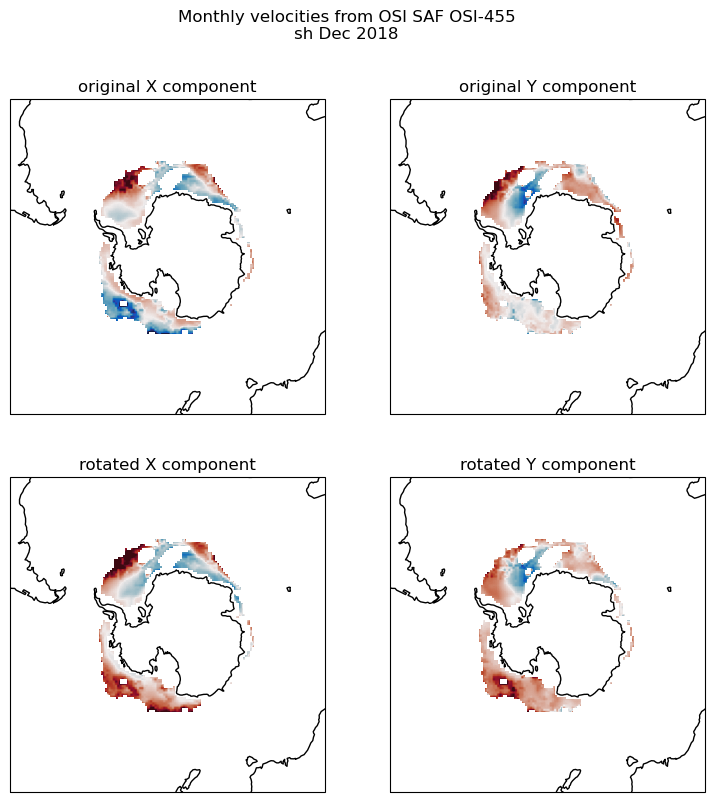

In [14]:
# plot the monthly mean velocity components (before and after rotation) from the OSI-455 product 
ccrs_from = pr.utils.load_cf_area(ds_osi455_month)[0].to_cartopy_crs()
plot_vector_components(ds_osi455_month['vX'].data, ds_osi455_month['vY'].data,
                       ds_osi455_month['vX_latlon'].data, ds_osi455_month['vY_latlon'].data,
                       ccrs_from, fig_title='Monthly velocities from OSI SAF OSI-455\n{a:} {d:%b %Y}'.format(a=area, d=nsidc_date))

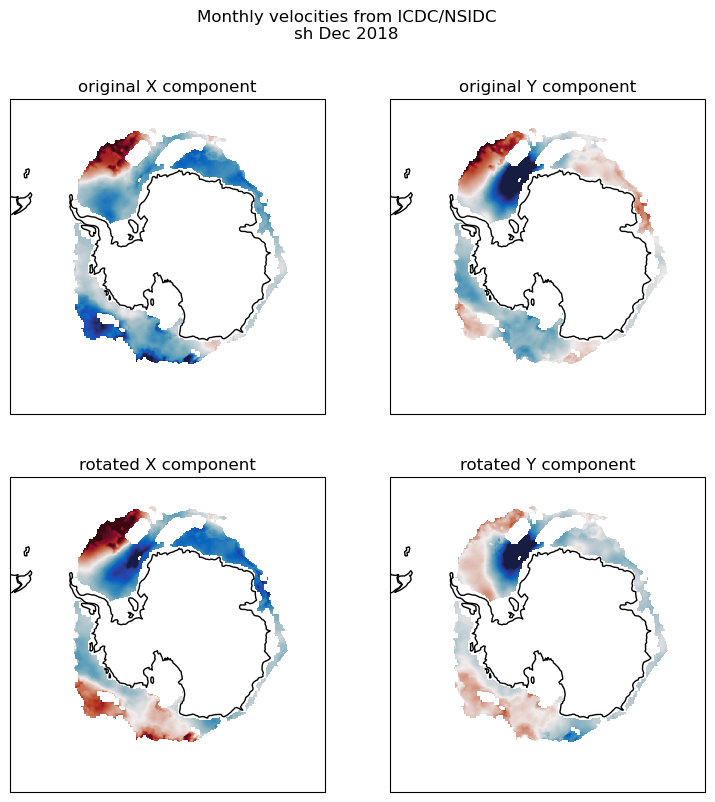

In [15]:
# plot the monthly mean velocity components (before and after rotation) from the ICDC product (based on NSIDC)
ccrs_from = adef_nsidc.to_cartopy_crs()
plot_vector_components(ds_icdc['ux'].isel(time=tindex), ds_icdc['vy'].isel(time=tindex),
                       ds_icdc['u'].isel(time=tindex), ds_icdc['v'].isel(time=tindex),
                       ccrs_from, fig_title='Monthly velocities from ICDC/NSIDC\n{a:} {d:%b %Y}'.format(a=area, d=nsidc_date))


### Application 2: Compute weekly mean velocity from the OSI SAF CDR and NRT products

OSI SAF delivers two sea-ice drift products: the Climate Data Record (CDR) and the Near Real Time product (NRT). They are not in the same grid. In addition, the CDR has a 24h drift duration while the NRT has 48h.

In the application below we compute weekly mean velocity vectors from both sources (expressed as km/d) and rotate the NRT vectors into the projection of the CDR. Note that this is for the purpose of technical demonstration, we do not claim this is how the two products should be compared or used together. 

In [16]:
area = 'nh'
dt = date(2019,12,14)

first_day, last_day = get_week_first_last_date(dt)
print(first_day, last_day)

2019-12-09 2019-12-15


In [17]:
# find the CDR files for the selected week
osi455_files = []
for d in rrule.rrule(rrule.DAILY, dtstart=first_day,
                                        until=last_day):
    osi455_files.append(find_sid_file(d, area=area, return_filename=True, source='cdr'))

print("Found {} OSI-455 (CDR) files:\n{}".format(len(osi455_files), osi455_files))
print()
# find the NRT files for the selected week
osi405_files = []
for d in rrule.rrule(rrule.DAILY, dtstart=first_day,
                                        until=last_day):
    osi405_files.append(find_sid_file(d, area=area, return_filename=True, source='nrt'))

print("Found {} OSI-405 (NRT) files:\n{}".format(len(osi405_files), osi405_files))

Found 7 OSI-455 (CDR) files:
['https://thredds.met.no/thredds/dodsC/osisaf/met.no/reprocessed/ice/drift_455m_files/merged/2019/12/ice_drift_nh_ease2-750_cdr-v1p0_24h-201912091200.nc', 'https://thredds.met.no/thredds/dodsC/osisaf/met.no/reprocessed/ice/drift_455m_files/merged/2019/12/ice_drift_nh_ease2-750_cdr-v1p0_24h-201912101200.nc', 'https://thredds.met.no/thredds/dodsC/osisaf/met.no/reprocessed/ice/drift_455m_files/merged/2019/12/ice_drift_nh_ease2-750_cdr-v1p0_24h-201912111200.nc', 'https://thredds.met.no/thredds/dodsC/osisaf/met.no/reprocessed/ice/drift_455m_files/merged/2019/12/ice_drift_nh_ease2-750_cdr-v1p0_24h-201912121200.nc', 'https://thredds.met.no/thredds/dodsC/osisaf/met.no/reprocessed/ice/drift_455m_files/merged/2019/12/ice_drift_nh_ease2-750_cdr-v1p0_24h-201912131200.nc', 'https://thredds.met.no/thredds/dodsC/osisaf/met.no/reprocessed/ice/drift_455m_files/merged/2019/12/ice_drift_nh_ease2-750_cdr-v1p0_24h-201912141200.nc', 'https://thredds.met.no/thredds/dodsC/osisaf/m

In [18]:
# open access to the files
ds_osi455 = xr.open_mfdataset(osi455_files)
ds_osi405 = xr.open_mfdataset(osi405_files)

In [19]:
# compute velocity vectors expressed in km/d
kwargs = {'method':'actual-duration', 'units':'km/d'}
ds_osi455 = ds_osi455.groupby('time', squeeze=False).apply(express_displacement_as_velocity,**kwargs)
ds_osi405 = ds_osi405.groupby('time', squeeze=False).apply(express_displacement_as_velocity,**kwargs)

In [20]:
# rotate the NRT vectors to the CDR grid
crs_to = pr.utils.load_cf_area(ds_osi455)[0].crs
args = (crs_to,)
kwargs = {'crs_tag':'ease2', 'velocity':True}
ds_osi405 = ds_osi405.groupby('time', squeeze=False).apply(rotate_icedrift_vectors,args,**kwargs)
# explore the rotated velocity
print(ds_osi405['vX_ease2'])

<xarray.DataArray 'vX_ease2' (time: 7, yc: 177, xc: 119)>
dask.array<concatenate, shape=(7, 177, 119), dtype=float32, chunksize=(1, 177, 119), chunktype=numpy.ndarray>
Coordinates:
  * time     (time) datetime64[ns] 2019-12-11T12:00:00 ... 2019-12-17T12:00:00
  * xc       (xc) float64 -3.75e+03 -3.688e+03 ... 3.562e+03 3.625e+03
  * yc       (yc) float64 5.75e+03 5.688e+03 5.625e+03 ... -5.188e+03 -5.25e+03
    lat      (yc, xc) float32 dask.array<chunksize=(177, 119), meta=np.ndarray>
    lon      (yc, xc) float32 dask.array<chunksize=(177, 119), meta=np.ndarray>
Attributes:
    long_name:            component of the velocity along the x axis of crs: ...
    standard_name:        sea_ice_x_velocity
    units:                km/d
    grid_mapping:         Polar_Stereographic_Grid
    ancillary_variables:  status_flag
    comment:              This variable is not part of the product, it was co...
    ease2_projstr:        +proj=laea +lat_0=90 +lon_0=0 +x_0=0 +y_0=0 +ellps=...


In [21]:
# compute the weekly mean velocity
ds_osi455_week = ds_osi455.mean(dim="time", keep_attrs=True)
ds_osi405_week = ds_osi405.mean(dim="time", keep_attrs=True)

In [22]:
# remap the NRT vector field from its Polar Stereographic (62.5 km) grid to the CDR EASE2 (75 km) grid.
#    this is only for the purpose of this demonstration, this remapping method is not particularly
#    optimized.
src_adef = pr.utils.load_cf_area(ds_osi405)[0]
trg_adef = pr.utils.load_cf_area(ds_osi455)[0]
osi405_vX_remapped = pr.kd_tree.resample_nearest(src_adef, ds_osi405_week['vX_ease2'].to_masked_array().filled(-999),
                                                 trg_adef, radius_of_influence=100000, fill_value=None)
osi405_vY_remapped = pr.kd_tree.resample_nearest(src_adef, ds_osi405_week['vY_ease2'].to_masked_array().filled(-999), trg_adef,
                                                 radius_of_influence=100000, fill_value=-999)
osi405_vX_remapped[osi405_vX_remapped==-999] = np.nan
osi405_vY_remapped[osi405_vY_remapped==-999] = np.nan

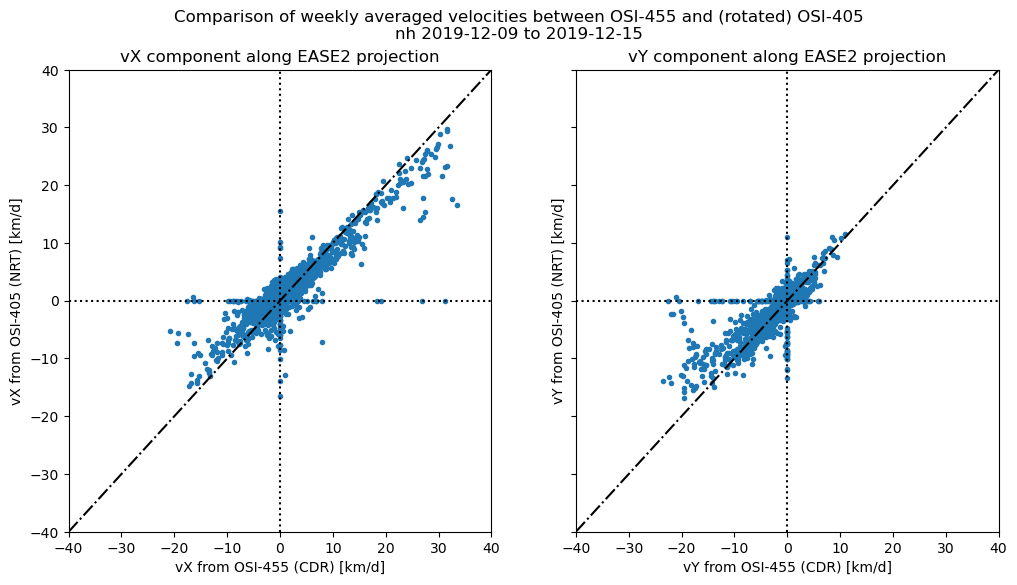

In [23]:
# compare the components as scatterplots
fig, (ax0, ax1) = plt.subplots(ncols=2, figsize=(12,6), sharex=True, sharey=True)
l, L = -40,+40

# dX panel
ax0.axhline(y=0, c='k', ls=':')
ax0.axvline(x=0, c='k', ls=':')
ax0.scatter(ds_osi455_week['vX'].to_numpy(), osi405_vX_remapped, marker='.')
ax0.plot([l,L],[l,L],'k-.')
ax0.set_xlim(l,L); ax0.set_ylim(l,L)
ax0.set_title('vX component along EASE2 projection')
ax0.set_xlabel('vX from OSI-455 (CDR) [{}]'.format(ds_osi455_week['vX'].units))
ax0.set_ylabel('vX from OSI-405 (NRT) [{}]'.format(ds_osi405_week['vX'].units))

# dY panel
ax1.axhline(y=0, c='k', ls=':')
ax1.axvline(x=0, c='k', ls=':')
ax1.scatter(ds_osi455_week['vY'].to_numpy(), osi405_vY_remapped, marker='.')
ax1.plot([l,L],[l,L],'k-.')
ax1.set_xlim(l,L); ax0.set_ylim(l,L)
ax1.set_title('vY component along EASE2 projection')
ax1.set_xlabel('vY from OSI-455 (CDR) [{}]'.format(ds_osi455_week['vY'].units))
ax1.set_ylabel('vY from OSI-405 (NRT) [{}]'.format(ds_osi405_week['vY'].units))

fig.suptitle('Comparison of weekly averaged velocities between OSI-455 and (rotated) OSI-405\n{} {} to {}'.format(area, first_day, last_day))
plt.show()